# Testing the optimization run for convergence

In [46]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np

from ema_workbench import Model, RealParameter, ScalarOutcome, HypervolumeMetric, GenerationalDistanceMetric
from ema_workbench.em_framework import ArchiveLogger, epsilon_nondominated 
from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem

from experimentation import data_generation
from model.model_nile import ModelNile


In [47]:
# # sns.set(font_scale=1.2)

# fm.fontManager.addfont("Minion Pro Regular.ttf")
# matplotlib.rc("font", family="Minion Pro")

# rcParams["font.family"] = "Minion Pro"
# rcParams["font.sans-serif"] = "Minion Pro"
# rcParams["font.size"] = 12

## 1. Data colleciton

### 1.1 The models used for experiments

In [48]:
# Define the subfolder names corresponding to different experiments.
max_nfe = ["nfe500000_None_bigger_48cpu"]
different_principles = ["nfe250000_uwf_biggest", "nfe250000_pwf_biggest", "nfe250000_gini_biggest"]
subfoldernames = different_principles

In [49]:
def get_principle(s):
    for principle in ["None", "uwf", "pwf", "gini"]:
        if principle in s:
            return principle
    raise ValueError("Invalid string, principle not recognized.")

In [50]:
def create_em_model(principle):
    nile_model = ModelNile(principle=principle)
    nile_model = data_generation.generate_input_data(nile_model, sim_horizon=20)
    
    em_model = Model("NileProblem", function=nile_model)

    parameter_count = nile_model.overarching_policy.get_total_parameter_count()
    n_inputs = nile_model.overarching_policy.functions["release"].n_inputs
    n_outputs = nile_model.overarching_policy.functions["release"].n_outputs
    p_per_RBF = 2 * n_inputs + n_outputs

    lever_list = list()
    for i in range(parameter_count):
        modulus = (i - n_outputs) % p_per_RBF
        if (
            (i >= n_outputs)
            and (modulus < (p_per_RBF - n_outputs))
            and (modulus % 2 == 0)
        ):  # centers:
            lever_list.append(RealParameter(f"v{i}", -1, 1))
        else:  # linear parameters for each release, radii, and weights of RBFs:
            lever_list.append(RealParameter(f"v{i}", 0, 1))

    em_model.levers = lever_list

    # specify outcomes
    em_model.outcomes = [
        ScalarOutcome("egypt_irr", ScalarOutcome.MINIMIZE),
        ScalarOutcome("egypt_90", ScalarOutcome.MINIMIZE),
        ScalarOutcome("egypt_low_had", ScalarOutcome.MINIMIZE),
        ScalarOutcome("sudan_irr", ScalarOutcome.MINIMIZE),
        ScalarOutcome("sudan_90", ScalarOutcome.MINIMIZE),
        ScalarOutcome("ethiopia_hydro", ScalarOutcome.MAXIMIZE),
    ]
    if principle != "None":
        em_model.outcomes.extend([ScalarOutcome("principle_result", ScalarOutcome.MAXIMIZE)])
    
    return em_model

In [51]:
em_models = []
problems = []
for subfolder in subfoldernames:
    print(subfolder)
    principle = get_principle(subfolder)
    em_model = create_em_model(principle)
    em_models.append(em_model)
    print("number of outcomes:", len(em_model.outcomes))
    problem = to_problem(em_model, searchover="levers")
    problems.append(problem)

nfe250000_uwf_biggest


number of outcomes: 7
nfe250000_pwf_biggest
number of outcomes: 7
nfe250000_gini_biggest
number of outcomes: 7


### 1.2 Results from experiments

In [52]:
# Initialize empty lists to store results and convergence data for each experiment.
results = []
convergences = []

# Loop through each subfolder (experiment) to extract results and convergence data.
for subfolder in subfoldernames:
    # Construct the path to the subfolder.
    subfolderpath = f"outputs/{subfolder}" 
    
    # Construct the file paths for the results and convergence CSV files for the current experiment.
    results_filepath = f"{subfolderpath}/baseline_results_{subfolder}.csv"
    convergence_filepath = f"{subfolderpath}/baseline_convergence_{subfolder}.csv"

    # Read the CSV files into DataFrames.
    result = pd.read_csv(results_filepath, index_col=0)
    convergence = pd.read_csv(convergence_filepath, index_col=[0])

    # Append the DataFrames to their respective lists.
    results.append(result)
    convergences.append(convergence)


In [53]:
# Displaying meta-information for the results and convergences
print(f"Number of elements in 'results': {len(results)}")
print(f"Number of elements in 'convergences': {len(convergences)}")

for idx, (result, convergence) in enumerate(zip(results, convergences)):
    print(f"\n--- Information for subfolder: {subfoldernames[idx]} ---")
    print(f"Shape of result DataFrame: {result.shape} (rows x columns)")
    print(f"Shape of convergence DataFrame: {convergence.shape} (rows x columns)")

Number of elements in 'results': 3
Number of elements in 'convergences': 3

--- Information for subfolder: nfe250000_uwf_biggest ---
Shape of result DataFrame: (8, 171) (rows x columns)
Shape of convergence DataFrame: (4, 2) (rows x columns)

--- Information for subfolder: nfe250000_pwf_biggest ---
Shape of result DataFrame: (3, 171) (rows x columns)
Shape of convergence DataFrame: (4, 2) (rows x columns)

--- Information for subfolder: nfe250000_gini_biggest ---
Shape of result DataFrame: (4, 171) (rows x columns)
Shape of convergence DataFrame: (4, 2) (rows x columns)


### Hypervolume and Generational distance with Platypus Metrics
To evaluate optimization convergence, we use Hypervolume and Generational Distance metrics from Platypus. For precise analysis, we need to load the necessary archived data into memory.

In [54]:
# Initialize an empty list to store archives for each experiment.
all_archives = []

# Loop through each subfolder (representing different experiments).
for subfolder in subfoldernames:
    # Construct the path to the current experiment's output folder and the archive file for the current experiment.
    subfolderpath = f"outputs/{subfolder}"
    archive_path = f"{subfolderpath}/archive_logs/archives.tar.gz"
    
    # Load the archives using the provided ArchiveLogger function.
    archives = ArchiveLogger.load_archives(archive_path)

    # Drop the first column from each archive dataframe
    for key in archives:
        archives[key] = archives[key].iloc[:, 1:]
    
    # Append the loaded archives to the main list.
    all_archives.append(archives)

In [55]:
print(f"Total number of archives: {len(all_archives)}")
for index, archive in enumerate(all_archives, 1):
    print(f"Archive {index}: {len(archive)} items")

Total number of archives: 3
Archive 1: 4 items
Archive 2: 4 items
Archive 3: 4 items


## 2 Convergence resultst

In [56]:
hvs = []
gds = []
# Iterate over each result and its corresponding problem.
for result, problem in zip(results, problems):
    print(problem)
    # Calculate Hypervolume and Generational Distance metrics for the current result.
    hv = HypervolumeMetric(result, problem)
    gd = GenerationalDistanceMetric(result, problem, d=1)
    
    # Append the metrics to their respective lists.
    hvs.append(hv)
    gds.append(gd)

In [57]:
from tqdm import tqdm

metrics_by_seed = []

# Iterate over each archive, hv, and gd simultaneously
for archives, current_hv, current_gd in zip(all_archives, hvs, gds):
    metrics = []
    for nfe, archive in tqdm(archives.items(), desc="Processing NFEs"):
        scores = {
            "generational_distance": current_gd.calculate(archive),
            "hypervolume": current_hv.calculate(archive),
            "nfe": int(nfe)
        }
        metrics.append(scores)
    
    metrics = pd.DataFrame.from_dict(metrics)
    # Sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

Processing NFEs: 100%|██████████| 4/4 [00:00<00:00, 34.88it/s]


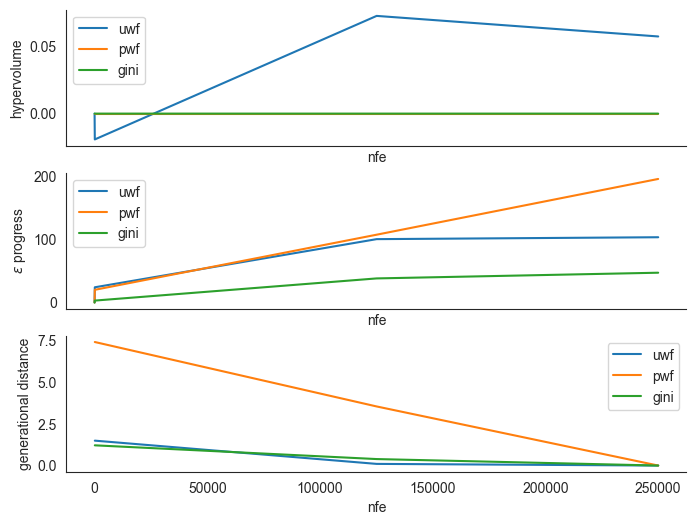

In [58]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=3, figsize=(8, 6), sharex=True)

ax1, ax2, ax3 = axes

principles = [get_principle(subfolder) for subfolder in subfoldernames]

for metrics, convergence, principle in zip(metrics_by_seed, convergences, principles):
    ax1.plot(metrics.nfe, metrics.hypervolume, label=principle)
    ax1.set_ylabel("hypervolume")
    
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=principle)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance, label=principle)
    ax3.set_ylabel("generational distance")

for ax in axes:
    ax.set_xlabel("nfe")
    ax.legend()  # Display the legend on each subplot

sns.despine(fig)

plt.show()